# Исследование для фитнес-центра "Культурист-датасаентист". Отток клиентов

Мы изучили индикаторы оттока клиентов, купивших карту фитнес-центра. С помощью исследования можно прогнозировать, уйдет покупатель или нет, на основе десятка параметров.

Шаг 1 [Импорт бибилиотек, изучение документов](#the_destination)

Шаг 2 [Исследование данных](#the_destination2)

Шаг 3 [Модель прогнозирования оттока пользователей](#the_destination3)

Шаг 4 [Кластеризация пользователей](#the_destination4)

Шаг 5 [Вывод](#the_destination5)

<a id='the_destination'></a>
## Импорт бибилиотек, изучение документов

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from datetime import timedelta
import datetime
import datetime as dt
import scipy.stats as stats
import requests
import regex as re
from bs4 import BeautifulSoup
from io import BytesIO
from io import StringIO
import math
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import math as mth
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error, mean_squared_error, r2_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans



In [2]:
df=pd.read_csv('/datasets/gym_churn.csv', sep=',')

In [3]:
df

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


У нас данные о 4 тысячах клиентов.

### Есть информация о 13 параметрах:

Churn — факт оттока в текущем месяце;

Текущие поля в датасете:

### Данные пользователя за предыдущий до проверки факта оттока месяц:

gender — пол
- Near_Location — проживание или работа в районе, где находится фитнес-центр
- Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента)
- Phone — наличие контактного телефона
- Age — возраст
- Lifetime — время с момента первого обращения в фитнес-центр (в месяцах)

### Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:

- Contract_period — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год)
- Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах)
- Group_visits — факт посещения групповых занятий
- Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента
- Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц
- Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон

Приведем названия колонок к нижнему регистру.

In [5]:
df.columns=df.columns.str.lower()

<a id='the_destination2'></a>
## Изучение данных

Изучим данные в каждой из колонок.

In [6]:
df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


На момент исследования клиенты в среднем пользовались услугами фитнес-центра в течение 3,7 месяцев. В среднем клиенты ходят в зал 1,9 раз в неделю. Максимум - 6 посещений в неделю. 41% посещали групповые занятия. В среднем покупатели тратят 147 рублей на дополнительные услуги.

Большинство покупателей (85%) проживают или работают в районе, где находится фитнес-центр. 30% пользователей пришли через промоакцию "приведи друга". 

Средний возраст покупателя - 29 лет, а самому старшему покупателю 41 год.

Посмотрим на распределение 0 и 1 в колонке churn. Тех, кто остался, в нашем датасете в три раза меньше, чем тех, кто ушел (1 тысяча клиентов против 2,9 тысяч).

In [7]:
df['churn'].value_counts()

0    2939
1    1061
Name: churn, dtype: int64

Для визуализации поделим наш датасет по типу данных, выделив те колонки, где содержатся булевы переменные.

In [8]:
df_yes_no=df[['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits', 'churn']]
df_disc=df[['age', 'avg_additional_charges_total', 'contract_period', 'month_to_end_contract', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 'churn']]

In [9]:
out=df_yes_no.query("churn==0")
stay=df_yes_no.query("churn==1")

Построим сотлбчатые гистограммы для булевых переменных.

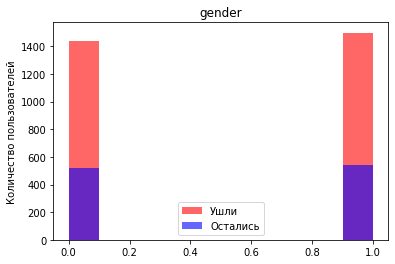

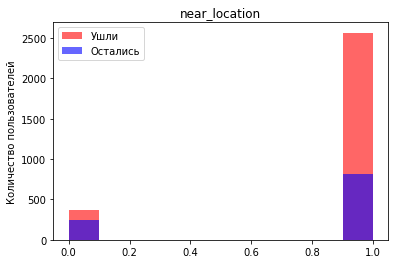

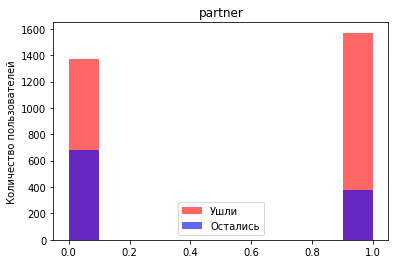

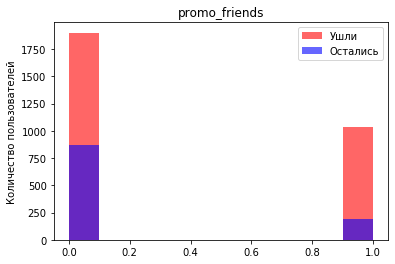

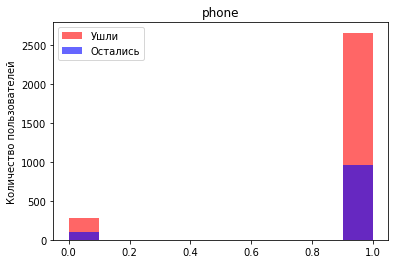

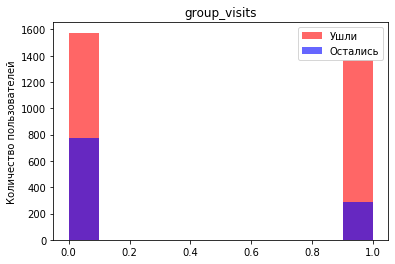

In [10]:
for col in df_yes_no.columns:
    if col != 'churn':
        plt.hist(out[col], label='Ушли', color='red', alpha=0.6, bins=10)
        plt.hist(stay[col], label='Остались', color='blue', alpha=0.6, bins=10)
        plt.ylabel('Количество пользователей')
        plt.title(col)
        plt.legend()
        plt.show()
    

Бросается в глаза, что среди тех, кто пришел по акции "приведи друга" или через компанию-партнера, бОльшая доля ушедших из клуба. Среди тех, кто посещает групповые занятия, меньшая доля оставшихся.

Проверим это.

In [11]:
df_yes_no_gr=df_yes_no.groupby(by='churn').mean()

In [12]:
df_yes_no_gr

,gender,near_location,partner,promo_friends,phone,group_visits
churn,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,0.464103
1,0.510839,0.768143,0.355325,0.183789,0.902922,0.268615


Действительно, среди тех, кто покинул фитнес-клуб, выше доля пришедших через "приведи друга" и партнеров.

Изучим распределение данных в остальных переменных.

In [13]:
df_disc_gr=df_disc.groupby('churn').mean()
df_disc_gr

,age,avg_additional_charges_total,contract_period,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,
0,29.976523,158.445715,5.747193,5.283089,4.711807,2.024876,2.027882
1,26.989632,115.082899,1.728558,1.662582,0.990575,1.474995,1.044546


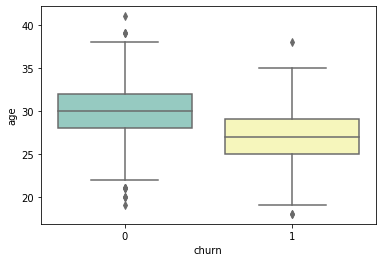

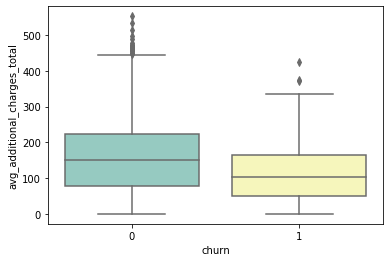

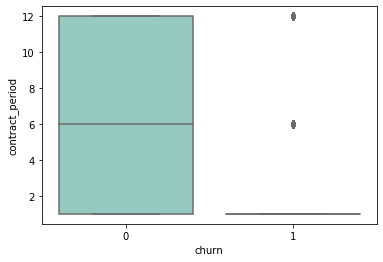

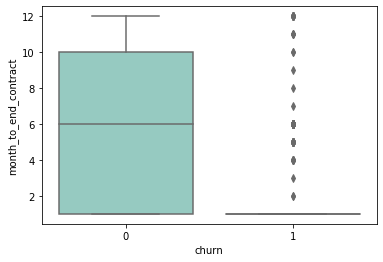

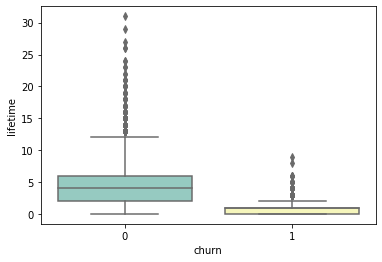

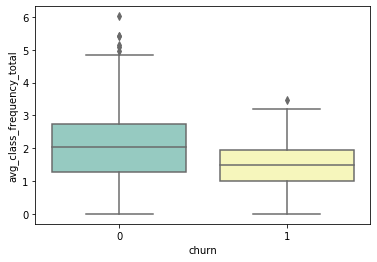

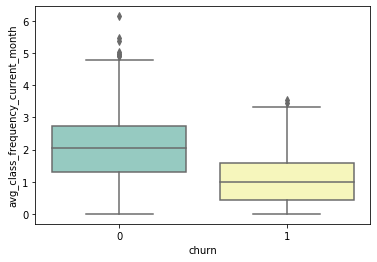

In [14]:
for col in df_disc.columns:
    if col != 'churn':
        sns.boxplot(x="churn", y=col, data=df_disc, palette="Set3")
        plt.show()


### Вывод

Тех, кто остался, в нашем датасете в три раза меньше, чем тех, кто ушел (1 тысяча клиентов против 2,9 тысяч).

На момент исследования клиенты в среднем пользовались услугами фитнес-центра в течение 3,7 месяцев. В среднем клиенты ходят в зал 1,9 раз в неделю. Максимум - 6 посещений в неделю. 41% посещали групповые занятия. В среднем покупатели тратят 147 рублей на дополнительные услуги.

Большинство покупателей (85%) проживают или работают в районе, где находится фитнес-центр. 30% пользователей пришли через промоакцию "приведи друга". 

Средний возраст покупателя - 29 лет, а самому старшему покупателю 41 год.

Те, кто ушел, ходили чаще - в среднем два раза в неделю против одного у тех, кто пока остался в клубе. Не исключено, что те, кто ходит на занятия чаще, быстрее перегорают.

Пользователи, покинувшие фитнес-центр, купили контракт в среднем 5,7 месяцев назад, а те, кто по-прежнему ходит в зал - около 2 месяцев назад.

Оставшиеся в клубе немного моложе, им в среднем около 27 лет, а тем, кто ушел - около 30. Те, кто остался, вносит меньше дополнительных платежей. Из этого можно сделать вывод, что те, кому не хватает услуг, входящих в абонемент, склонны покинуть фитнес-центр.

Среди тех, кто пришел по акции "приведи друга" или через компанию-партнера, бОльшая доля ушедших из клуба. Среди тех, кто посещает групповые занятия, меньшая доля оставшихся.


Построим матрицу корреляций.

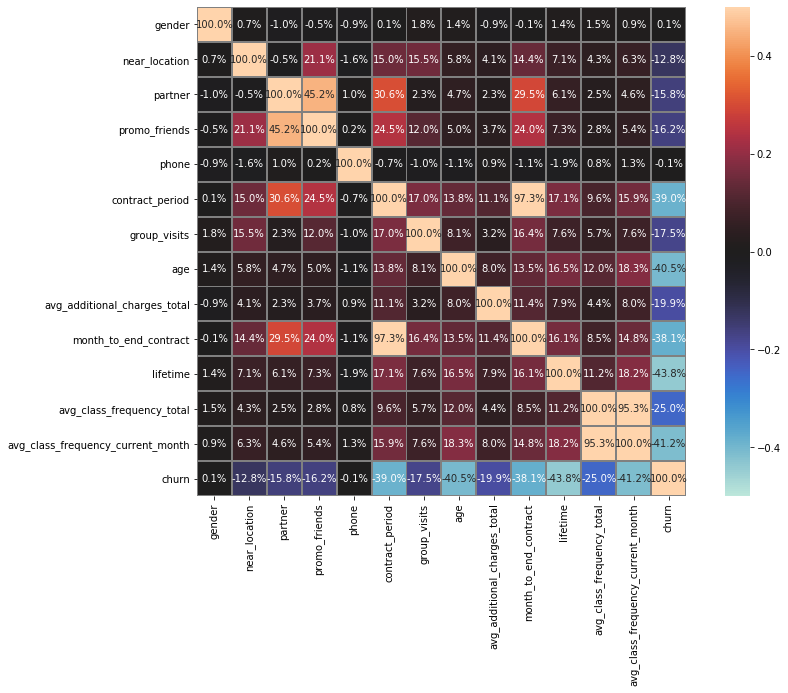

In [15]:
plt.figure(figsize=(14,9))

cm = df.corr() #вычисляем матрицу корреляций
#fig, ax = plt.subplots()

#нарисуем тепловую карту с подписями для матрицы корреляций
sns.heatmap(cm, annot = True, square=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=-0.5, vmax=0.5, center= 0)
#ваш код здесь
#корректировка "рваных" полей heatmap в последней версии библиотеки
plt.show()


Есть большая корреляция между двумя парами переменных - month_to_end_contract и contract_period, avg_class_frequency_current_month и avg_class_frequency_total. Для теста удалим по одному из этих параметров.

Есть корреляция между фактом использования акции "приведи друга" и работы в партнерской компании. Возможно, коллеги договариваются между собой, чтобы воспользоваться акцией.



In [16]:
df2=df.drop(columns =['month_to_end_contract','avg_class_frequency_current_month'], axis = 1) 
#df2=df.drop(columns =['age'], axis = 1) 

Те, кто ушел, ходили в зал чаще - в среднем два раза в неделю против одного у тех, кто пока остался в клубе. Не исключено, что те, кто ходит на занятия чаще, быстрее перегорают.

Пользователи, покинувшие фитнес-центр, купили контракт в среднем 5,7 месяцев назад, а те, кто по-прежнему ходит в зал - около 2 месяцев назад.

Оставшиеся в клубе немного моложе, им в среднем около 27 лет, а тем, кто ушел - около 30. Те, кто остался, вносит меньше дополнительных платежей. Из этого можно сделать вывод, что те, кому не хватает услуг, входящих в абонемент, склонны покинуть фитнес-центр.

<a id='the_destination3'></a>
## Модель прогнозирования оттока пользователей

Построим модель прогнозирования оттока пользователей. Обучим модель двумя способами - логистической регрессией
случайным лесом - и сравним результаты.
Сделаем это для датасета с удаленными столбцами и без.

In [17]:
X = df.drop('churn', axis = 1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
    
def ml(our_model, name):
    model = our_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(name)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))

 
ml(LogisticRegression(random_state=0), "LogisticRegression")
ml(RandomForestClassifier(random_state=0), "RandomForestClassifier")


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


LogisticRegression
Accuracy: 0.93
Precision: 0.86
Recall: 0.83
f1: 0.85
RandomForestClassifier
Accuracy: 0.91
Precision: 0.83
Recall: 0.78
f1: 0.81


In [18]:
X = df2.drop('churn', axis = 1)
y = df2['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
 
    
def ml(our_model, name):
    model = our_model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    print(name)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))


 
ml(LogisticRegression(random_state=0), "LogisticRegression")
ml(RandomForestClassifier(random_state=0), "RandomForestClassifier")


LogisticRegression
Accuracy: 0.88
Precision: 0.76
Recall: 0.77
f1: 0.77
RandomForestClassifier
Accuracy: 0.88
Precision: 0.77
Recall: 0.73
f1: 0.75


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Удалив два столбца, мы ухудшили результаты. Не будем их удалять.

### Вывод
Наша модель правильно предсказывает, уйдет ли клиент, в 92% случаев.

<a id='the_destination4'></a>
## Кластеризация

Поделим клиентов фитнес-клуба на кластеры. 

In [ ]:
X = df.drop('churn', axis = 1)

sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Определим число кластеров как 5, так как последний кластер, закрашенный фиолетовым, слишком велик, можно его разделить на два.

In [ ]:
cluster = KMeans(n_clusters = 5)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = cluster.fit_predict(X_sc)
 
# сохраняем метки кластера в поле датасета
df['cluster'] = labels


In [ ]:
df

Посмотрим на средние значения признаков в разных кластерах.

In [ ]:
df['cluster'].value_counts()

In [ ]:
df_clusters=df.groupby(by="cluster").mean().reset_index()

In [ ]:
df_clusters

In [ ]:
plt.subplots(figsize=(20,20))
i=1
df_clusters['colors'] = 'red'
df_clusters.loc[df_clusters.churn>0.2,'colors'] = 'green'

for col in df_clusters.columns:
    if col != 'cluster' and col != 'colors':
    
        df_clusters[col]\
        .plot(kind = 'bar', x = col, color = df_clusters.colors, alpha=0.6, ax=plt.subplot(4,4,i), zorder=3)\
        .set_title(col)
        i += 1
        plt.grid(zorder=0, axis="y")

            

        
plt.show()

У нас образовалось 5 кластеров, в трех из которых - 1, 2 и 3 - высокий и средний показатель "приверженности" к фитнес-клубу, то есть доля клиентов, которые продолжают заниматься. Наивысший показатель - в кластере 1. Интересно, что в этом кластере нет тех, кто проживает или работает рядом с фитнес-клубом. Возможно, они заезжают в клуб по дороге с работы домой. Можно было бы предположить, что это фанаты тренеров, работающих в клубе. Против этой версии говорит то, что они почти не посещают групповые занятия.

В двух других кластерах, где высокая доля тех, кто ходит в клуб, доля проживающих или работающих в одном районе с клубом немного выше, чем в остальных кластерах.

Те, кто ходил в зал часто, с высокой вероятностью впоследствии переставал пользоваться фитнес-клубом.

Те, у кого годовые абонементы, с высокой вероятностью откажутся от занятий.

Те, кто платит за дополнительные услуги, с более высокой вероятностью покинут клуб, чем те, кто не платит.

Среди пришедших по акции "Приведи друга" много последующих "отказов", но сформировался кластер, где средний показатель "приверженности" выше.

Посещение групповых занятий больше ассоциировано с отказом.

Те, кто продолжает занятие, немного моложе тех, кто уходит.

### Вывод

Мы поделили клиентов фитнес-клуба на 5 кластеров. Среди них выделяются три кластера, где клиенты продолжают заниматься.

Наивысший показатель - в кластере 1. Интересно, что в этом кластере нет тех, кто проживает или работает рядом с фитнес-клубом. Возможно, они заезжают в клуб по дороге с работы домой. Можно было бы предположить, что это фанаты тренеров, работающих в клубе. Против этой версии говорит то, что они почти не посещают групповые занятия.

В двух других кластерах, где высокая доля тех, кто ходит в клуб, доля проживающих или работающих в одном районе с клубом немного выше, чем в остальных кластерах.

Те, кто ходил в зал часто, с высокой вероятностью впоследствии переставал пользоваться фитнес-клубом.

те, у кого годовые абонементы, с высокой вероятностью откажутся от занятий.

Те, кто платит за дополнительные услуги, с более высокой вероятностью покинут клуб, чем те, кто не платит.

Среди пришедших по акции "Приведи друга" много "отказов", но сформировался кластер, где средний показатель "приверженности".

Посещение групповых занятий больше ассоциировано с отказом.

Те, кто продолжает занятие, немного моложе тех, кто уходит.

## Приложение

Посмотрим на распределение признаков в каждом из кластеров.

In [ ]:
cluster_names=df['cluster'].unique()

In [ ]:
print(type(cluster_names))

In [ ]:
cluster_names=df['cluster'].unique()
def cluster_hist(col):
    fig, axes = plt.subplots(1, 5, figsize=(16, 2), sharex='col', sharey='row')
    fig.suptitle(col)
    for i in cluster_names:
        df_clusters_query=df.query('cluster=='+i.astype(str))
        df_clusters_query[col].hist(alpha=0.6, bins=10, ax=axes[i], color='#00bcd4').set_title(i, y=0.82)

    

for col in df.columns:
    cluster_hist(col)

## Вывод

Мы проанализировали данные о 4 тысячах клиентов фитнес-центра "Культурист-датасаентист". Тех, кто продолжает занятия, в нашем датасете в три раза меньше, чем тех, кто ушел (1 тысяча клиентов против 2,9 тысяч).

Мы построили модель, которая предсказывает с точностью 92%, уйдет ли посетитель.

Выяснилось, что есть факторы, которые свидетельствуют о скором отказе клиента от занятий.

Среди них: частые посещения спортзала (2 раза в неделю и чаще), траты на дополнительные услуги (больше 160 рублей), посещение групповых занятий.

Промоакции "приведи друга" и работа с компаниями-партнерами помогают привести посетителей, но многие из них не задерживаются.

Рекомендации:

Если "Культурист-датасаентист" хочет, чтобы клиенты оставались в зале дольше, можно сделать вот что:

- Помочь тем, кто ходит в зал часто, спланировать реалистичную переодичность тренировок. Это поможет им продолжить тренировки в тот период, когда воодушевление после покупки абонемента закончится.
- Прояснить, есть ли проблемы с групповыми занятиями. Может быть, посетителям не нравятся тренеры или расписание занятий. Возможно, они не знают, как заниматься без тренера. Стоит включить в абонемент индивидуальное занятие на тренажерах.
- Оценить коммерческую эффективность акций "Приведи друга" и работы с компаниями.
